Setup the environment to use TensorFlow, Keras, and Dataset (GOPRO,Berkely segmentation dataset 500 (BSD500)) manipulation

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import tensorflow as tf
from tensorflow.keras import layers, models

# For motion blur
import cv2

# For data loading & augmentation
import tensorflow_datasets as tfds


In [13]:
from tensorflow.image import psnr, ssim

def evaluate_psnr_ssim(model, dataset, max_val=1.0):
    psnr_vals = []
    ssim_vals = []

    for noisy, clean in dataset:
        denoised = model.predict(noisy, verbose=0)
        for i in range(denoised.shape[0]):
            psnr_val = psnr(clean[i], denoised[i], max_val=max_val).numpy()
            ssim_val = ssim(clean[i], denoised[i], max_val=max_val).numpy()
            psnr_vals.append(psnr_val)
            ssim_vals.append(ssim_val)

    mean_psnr = sum(psnr_vals) / len(psnr_vals)
    mean_ssim = sum(ssim_vals) / len(ssim_vals)
    return mean_psnr, mean_ssim


In [14]:
import os
import numpy as np
from PIL import Image

def load_gopro_dataset(blur_dir, sharp_dir, image_size=(256, 256), limit=None):
    X_blur = []
    Y_sharp = []

    blur_images = sorted(os.listdir(blur_dir))[:limit]
    for img_name in blur_images:
        blur_path = os.path.join(blur_dir, img_name)
        sharp_path = os.path.join(sharp_dir, img_name)  # same filename assumed

        # Load and preprocess
        blur_img = Image.open(blur_path).convert('L').resize(image_size)
        sharp_img = Image.open(sharp_path).convert('L').resize(image_size)

        # Normalize and expand dims to (H, W, 1)
        blur_np = np.expand_dims(np.array(blur_img).astype('float32') / 255., axis=-1)
        sharp_np = np.expand_dims(np.array(sharp_img).astype('float32') / 255., axis=-1)


        # Ensure 3 channels
        if blur_np.ndim == 2:
            blur_np = np.expand_dims(blur_np, -1)
        if sharp_np.ndim == 2:
            sharp_np = np.expand_dims(sharp_np, -1)

        X_blur.append(blur_np)
        Y_sharp.append(sharp_np)

    return np.array(X_blur), np.array(Y_sharp)


In [15]:
def load_gopro_dataset_all(data_dir, image_size=(256, 256), limit_per_sequence=None):
    def load_split(split):
        X_total, Y_total = [], []
        split_path = os.path.join(data_dir, split)
        sequences = sorted(os.listdir(split_path))

        for seq in sequences:
            blur_dir = os.path.join(split_path, seq, "blur")
            sharp_dir = os.path.join(split_path, seq, "sharp")

            if os.path.exists(blur_dir) and os.path.exists(sharp_dir):
                print(f"Loading {split}/{seq}...")
                X_blur, Y_sharp = load_gopro_dataset(
                    blur_dir, sharp_dir,
                    image_size=image_size,
                    limit=limit_per_sequence
                )
                X_total.extend(X_blur)
                Y_total.extend(Y_sharp)

        return np.array(X_total), np.array(Y_total)

    X_train, Y_train = load_split("train")
    X_test, Y_test = load_split("test")
    return (X_train, Y_train), (X_test, Y_test)


In [16]:
def add_gaussian_noise(img_array, mean=0.0, std=0.05):
    noise = np.random.normal(mean, std, img_array.shape)
    noisy_img = img_array + noise
    return np.clip(noisy_img, 0., 1.)

In [17]:
def process_bsd500_gaussian_blur_noise(image_dir, image_size=(256, 256), limit=None, blur_radius=2.5, noise_std=0.05):
    X_clean = []
    X_noisy = []

    image_files = sorted(os.listdir(image_dir))[:limit]

    for fname in image_files:
        path = os.path.join(image_dir, fname)
        try:
            img = Image.open(path).convert('L').resize(image_size)

            # Original clean image
            clean_np = np.array(img).astype('float32') / 255.
            clean_np = np.expand_dims(clean_np, axis=-1)  # Add channel dim (H, W, 1)

            # Apply Gaussian blur
            blurred_img = img.filter(ImageFilter.GaussianBlur(radius=blur_radius))
            blurred_np = np.array(blurred_img).astype('float32') / 255.
            blurred_np = np.expand_dims(blurred_np, axis=-1)  # Add channel dim (H, W, 1)

            # Add Gaussian noise
            noisy_np = add_gaussian_noise(blurred_np, std=noise_std)

            X_clean.append(clean_np)
            X_noisy.append(noisy_np)
        except Exception as e:
            print(f"Error processing {path}: {e}")

    return np.array(X_noisy), np.array(X_clean)



In [ ]:
import tensorflow as tf

def create_tf_dataset(X_input, X_target, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X_input, X_target))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X_input))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


'def create_tf_dataset(X_input, X_target, batch_size=16, shuffle=True):\n    def gen():\n        for x, y in zip(X_input, X_target):\n            yield x, y\n\n    dataset = tf.data.Dataset.from_generator(\n        gen,\n        output_signature=(\n            tf.TensorSpec(shape=X_input.shape[1:], dtype=tf.float32),\n            tf.TensorSpec(shape=X_target.shape[1:], dtype=tf.float32)\n        )\n    )\n\n    if shuffle:\n        dataset = dataset.shuffle(buffer_size=1024)\n\n    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)\n    return dataset '

In [19]:
"""from tensorflow.keras import layers, Model

def build_pres_unet(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(64, 3, padding="same", activation="relu")(p1)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(128, 3, padding="same", activation="relu")(p2)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(256, 3, padding="same", activation="relu")(p3)
    c4 = layers.BatchNormalization()(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # Bottleneck
    bn = layers.Conv2D(512, 3, padding="same", activation="relu")(p4)
    bn = layers.BatchNormalization()(bn)

    # Decoder
    u4 = layers.UpSampling2D(2)(bn)
    u4 = layers.Concatenate()([u4, c4])
    d4 = layers.Conv2D(256, 3, padding="same", activation="relu")(u4)
    d4 = layers.BatchNormalization()(d4)

    u3 = layers.UpSampling2D(2)(d4)
    u3 = layers.Concatenate()([u3, c3])
    d3 = layers.Conv2D(128, 3, padding="same", activation="relu")(u3)
    d3 = layers.BatchNormalization()(d3)

    u2 = layers.UpSampling2D(2)(d3)
    u2 = layers.Concatenate()([u2, c2])
    d2 = layers.Conv2D(64, 3, padding="same", activation="relu")(u2)
    d2 = layers.BatchNormalization()(d2)

    u1 = layers.UpSampling2D(2)(d2)
    u1 = layers.Concatenate()([u1, c1])
    d1 = layers.Conv2D(32, 3, padding="same", activation="relu")(u1)
    d1 = layers.BatchNormalization()(d1)

    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d1)

    return Model(inputs, outputs, name="PresUNet")
"""

'from tensorflow.keras import layers, Model\n\ndef build_pres_unet(input_shape=(256, 256, 1)):\n    inputs = layers.Input(shape=input_shape)\n\n    # Encoder\n    c1 = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs)\n    c1 = layers.BatchNormalization()(c1)\n    p1 = layers.MaxPooling2D(2)(c1)\n\n    c2 = layers.Conv2D(64, 3, padding="same", activation="relu")(p1)\n    c2 = layers.BatchNormalization()(c2)\n    p2 = layers.MaxPooling2D(2)(c2)\n\n    c3 = layers.Conv2D(128, 3, padding="same", activation="relu")(p2)\n    c3 = layers.BatchNormalization()(c3)\n    p3 = layers.MaxPooling2D(2)(c3)\n\n    c4 = layers.Conv2D(256, 3, padding="same", activation="relu")(p3)\n    c4 = layers.BatchNormalization()(c4)\n    p4 = layers.MaxPooling2D(2)(c4)\n\n    # Bottleneck\n    bn = layers.Conv2D(512, 3, padding="same", activation="relu")(p4)\n    bn = layers.BatchNormalization()(bn)\n\n    # Decoder\n    u4 = layers.UpSampling2D(2)(bn)\n    u4 = layers.Concatenate()([u4, c4])\n    d

In [20]:
from tensorflow.keras import layers, Model

def build_autoencoder_v2(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)  # 128x128

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)  # 64x64

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)  # 32x32

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)  # 16x16

    # Bottleneck
    bn = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    bn = layers.Conv2D(1024, 3, activation='relu', padding='same')(bn)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(bn)
    u4 = layers.Concatenate()([u4, c4])
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(512, 3, activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3 = layers.Concatenate()([u3, c3])
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(256, 3, activation='relu', padding='same')(c6)

    u2 = layers.UpSampling2D((2, 2))(c6)
    u2 = layers.Concatenate()([u2, c2])
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(128, 3, activation='relu', padding='same')(c7)

    u1 = layers.UpSampling2D((2, 2))(c7)
    u1 = layers.Concatenate()([u1, c1])
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(64, 3, activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(c8)

    return Model(inputs, outputs, name="DeepUNetAutoencoder")


In [21]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available:", gpus[0])
else:
    print("No GPU detected — training may be slow.")


GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [22]:
if __name__ == '__main__':
    # Load the dataset
    # Make sure to set the correct path to your dataset
    # The dataset should be structured as:
    # GoPro/
    # ├── train/
    # │   ├── sequence_1/
    # │   │   ├── blur/
    # |   |   ├── blur_gamma
    # │   │   └── sharp/
    # │   └── sequence_2/
    # │       ├── blur/
    # |       ├── blur_gamma
    # │       └── sharp/
    # └── test/
    #     ├── sequence_1/
    #     │   ├── blur/
    #     |   ├── blur_gamma
    #     │   └── sharp/
    #     └── sequence_2/
    #         ├── blur/
    #         ├── blur_gamma
    #         └── sharp/


    # BSDS500/ 
    #       ├── images/
    #       │   │   ├── train/
    #       │   │   ├── test/
    #       │   │   └── val/
    #       │   └── groundTruth/
    #       │       ├── train/
    #       │       ├── test/
    #       │       └── val/


    # === GoPro Dataset ===
    data_path = "../../../GOPRO"  # adjust as needed
    (X_train_gopro, Y_train_gopro), (X_test_gopro, Y_test_gopro) = load_gopro_dataset_all(
        data_dir=data_path,
        image_size=(256, 256),
        limit_per_sequence=200
    )
    print("GoPro train:", X_train_gopro.shape, Y_train_gopro.shape)
    print("GoPro test:", X_test_gopro.shape, Y_test_gopro.shape)

    test_dataset_gopro = create_tf_dataset(X_test_gopro, Y_test_gopro, batch_size=16, shuffle=False)

    from sklearn.model_selection import train_test_split

    # Split 10% of training into validation set
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_train_gopro, Y_train_gopro, test_size=0.1, random_state=42
    )

    # === BSD500 Dataset ===
    bsd_path = "../../../BSD500/images/train"  # update this to your extracted BSD path

    X_bsd_blur, X_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_path,
        image_size=(256, 256),
        limit=200,
        blur_radius=2.5,
        noise_std=0.05
    )
    print("BSD500 processed:", X_bsd_blur.shape, X_bsd_clean.shape)

    # === Convert BSD to tf.data.Dataset ===
    bsd_dataset = create_tf_dataset(X_bsd_blur, X_bsd_clean, batch_size=16)

    #show a batch
    for noisy, clean in bsd_dataset.take(1):
        print("Batch sample shapes:", noisy.shape, clean.shape)
    

    # Combine BSD500 + GoPro training data
    X_combined = np.concatenate([X_bsd_blur, X_train], axis=0)
    Y_combined = np.concatenate([X_bsd_clean, Y_train], axis=0)

    print("Combined training dataset shape:", X_combined.shape)
    print("→ From BSD500:", X_bsd_blur.shape[0])
    print("→ From GoPro:", X_train.shape[0])


    # === BSD500 Validation ===
    bsd_val_path = "../../../BSD500/images/val"
    X_val_bsd_blur, X_val_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_val_path,
        image_size=(256, 256),
        limit=None,
        blur_radius=2.5,
        noise_std=0.05
    )
    val_dataset_bsd = create_tf_dataset(X_val_bsd_blur, X_val_bsd_clean, batch_size=16, shuffle=False)

    bsd_test_path = "../../../BSD500/images/test"
    X_test_bsd_blur, X_test_bsd_clean = process_bsd500_gaussian_blur_noise(
        image_dir=bsd_test_path,
        image_size=(256, 256),
        limit=None,
        blur_radius=2.5,
        noise_std=0.05
    )
    test_dataset_bsd = create_tf_dataset(X_test_bsd_blur, X_test_bsd_clean, batch_size=16, shuffle=False)

    train_dataset = create_tf_dataset(X_combined, Y_combined, batch_size=16, shuffle=True)
    val_dataset   = create_tf_dataset(X_val, Y_val, batch_size=16, shuffle=False)



Loading train/GOPR0372_07_00...
Loading train/GOPR0372_07_01...
Loading train/GOPR0374_11_00...
Loading train/GOPR0374_11_01...
Loading train/GOPR0374_11_02...
Loading train/GOPR0374_11_03...
Loading train/GOPR0378_13_00...
Loading train/GOPR0379_11_00...
Loading train/GOPR0380_11_00...
Loading train/GOPR0384_11_01...
Loading train/GOPR0384_11_02...
Loading train/GOPR0384_11_03...
Loading train/GOPR0384_11_04...
Loading train/GOPR0385_11_00...
Loading train/GOPR0386_11_00...
Loading train/GOPR0477_11_00...
Loading train/GOPR0857_11_00...
Loading train/GOPR0868_11_01...
Loading train/GOPR0868_11_02...
Loading train/GOPR0871_11_01...
Loading train/GOPR0881_11_00...
Loading train/GOPR0884_11_00...
Loading test/GOPR0384_11_00...
Loading test/GOPR0384_11_05...
Loading test/GOPR0385_11_01...
Loading test/GOPR0396_11_00...
Loading test/GOPR0410_11_00...
Loading test/GOPR0854_11_00...
Loading test/GOPR0862_11_00...
Loading test/GOPR0868_11_00...
Loading test/GOPR0869_11_00...
Loading test/GOPR

I0000 00:00:1745856743.139709    2822 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745856743.143760    2822 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745856743.146817    2822 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1745856743.317870    2822 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

BSD500 processed: (200, 256, 256, 1) (200, 256, 256, 1)
Batch sample shapes: (16, 256, 256, 1) (16, 256, 256, 1)


2025-04-28 16:12:26.658607: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Combined training dataset shape: (2092, 256, 256, 1)
→ From BSD500: 200
→ From GoPro: 1892
Error processing ../../../BSD500/images/val/Thumbs.db: cannot identify image file '../../../BSD500/images/val/Thumbs.db'
Error processing ../../../BSD500/images/test/Thumbs.db: cannot identify image file '../../../BSD500/images/test/Thumbs.db'


2025-04-28 16:12:30.929360: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1096810496 exceeds 10% of free system memory.


In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Save the best model based on validation loss
checkpoint_cb = ModelCheckpoint(
    "best_model.h5",  # Save to file
    save_best_only=True,
    monitor="val_loss", 
    mode="min",  # Lower val_loss is better
    verbose=1
)

# Stop training early if no improvement after 5 epochs
earlystop_cb = EarlyStopping(
    monitor="val_loss",
    patience=5, 
    restore_best_weights=True,
    verbose=1
)

callbacks_list = [checkpoint_cb, earlystop_cb]


In [24]:
# === Build and compile model ===
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import AdamW
import tensorflow.image as tfi

def psnr_metric(y_true, y_pred):
    return tfi.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tfi.ssim(y_true, y_pred, max_val=1.0)

EPOCHS = 35

# Cosine decay: starts at 1e-3 and decays over 35 epochs
steps_per_epoch = len(train_dataset)
total_steps = steps_per_epoch * EPOCHS

lr_schedule = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=total_steps,
    alpha=1e-2  # final learning rate = alpha * initial_learning_rate
)


def combined_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    return 0.5 * mse + 0.5 * mae

autoencoder = build_autoencoder_v2(input_shape=(256, 256, 1)) #UPDATE TO CHAANE THE MODEL
#autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.compile(optimizer=AdamW(learning_rate=lr_schedule), loss=combined_loss, metrics=[psnr_metric, ssim_metric])

train_losses = []
val_losses_gopro = []
val_losses_bsd = []



for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    learning_rates = []

    # 1. Train for 1 epoch
    history = autoencoder.fit(train_dataset, validation_data=val_dataset, epochs=1, verbose=1, callbacks=callbacks_list)

    # 2. Save training + GoPro val loss
    train_losses.append(history.history['loss'][0])
    val_losses_gopro.append(history.history['val_loss'][0])

    # 3. Evaluate on BSD500 val set
    val_loss_bsd = autoencoder.evaluate(val_dataset_bsd, verbose=0)
    val_losses_bsd.append(val_loss_bsd)

    current_step = autoencoder.optimizer.iterations.numpy()

    # Check if learning_rate is a schedule or a fixed tensor
    if callable(autoencoder.optimizer.learning_rate):
        current_lr = tf.keras.backend.get_value(autoencoder.optimizer.learning_rate(current_step))
    else:
        current_lr = tf.keras.backend.get_value(autoencoder.optimizer.learning_rate)

    learning_rates.append(current_lr)
    print(f"Current LR: {current_lr:.6f}")







Epoch 1/35


I0000 00:00:1745856760.642518    2880 service.cc:146] XLA service 0x7716e0004030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745856760.642553    2880 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2025-04-28 16:12:40.870797: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1745856761.264103    2880 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1745856761.264917    2880 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1745856761.266411    2880 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1745856761.267056    2880 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1745856761.267824    2880 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1745856761.268

130/131 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0626 - psnr_metric: 19.4110 - ssim_metric: 0.5976

W0000 00:00:1745856825.866497    2881 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1745856825.866782    2881 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1745856825.867222    2881 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1745856825.867418    2881 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1745856825.867656    2881 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1745856825.867843    2881 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
2025-04-28 16:13:52.912357: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.96GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
E0000 00:00:1745856833.616082    2881 gpu_timer.cc:183] Delay kernel timed out: measur

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - loss: 0.0624 - psnr_metric: 19.4386 - ssim_metric: 0.5985

W0000 00:00:1745856852.616053    2881 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1745856852.616755    2881 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert
W0000 00:00:1745856852.618167    2881 assert_op.cc:38] Ignoring Assert operator SSIM/Assert/Assert
W0000 00:00:1745856852.618725    2881 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_1/Assert
W0000 00:00:1745856852.619424    2881 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_2/Assert
W0000 00:00:1745856852.619922    2881 assert_op.cc:38] Ignoring Assert operator SSIM/Assert_3/Assert
W0000 00:00:1745856856.731579    2880 assert_op.cc:38] Ignoring Assert operator PSNR/Assert/Assert
W0000 00:00:1745856856.731796    2880 assert_op.cc:38] Ignoring Assert operator PSNR/Assert_1/Assert



Epoch 1: val_loss improved from inf to 0.01734, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 106s 501ms/step - loss: 0.0622 - psnr_metric: 19.4657 - ssim_metric: 0.5994 - val_loss: 0.0173 - val_psnr_metric: 26.4327 - val_ssim_metric: 0.8161
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000998

Epoch 2/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0174 - psnr_metric: 26.7250 - ssim_metric: 0.8037
Epoch 1: val_loss improved from 0.01734 to 0.01553, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0173 - psnr_metric: 26.7259 - ssim_metric: 0.8037 - val_loss: 0.0155 - val_psnr_metric: 27.4882 - val_ssim_metric: 0.8351
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000992

Epoch 3/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0172 - psnr_metric: 27.0345 - ssim_metric: 0.8037
Epoch 1: val_loss improved from 0.01553 to 0.01517, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - loss: 0.0172 - psnr_metric: 27.0346 - ssim_metric: 0.8037 - val_loss: 0.0152 - val_psnr_metric: 27.6717 - val_ssim_metric: 0.8356
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000982

Epoch 4/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0168 - psnr_metric: 27.2535 - ssim_metric: 0.8056
Epoch 1: val_loss improved from 0.01517 to 0.01515, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - loss: 0.0168 - psnr_metric: 27.2543 - ssim_metric: 0.8056 - val_loss: 0.0152 - val_psnr_metric: 27.7892 - val_ssim_metric: 0.8383
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000968

Epoch 5/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0159 - psnr_metric: 27.6679 - ssim_metric: 0.8118
Epoch 1: val_loss improved from 0.01515 to 0.01487, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0159 - psnr_metric: 27.6677 - ssim_metric: 0.8118 - val_loss: 0.0149 - val_psnr_metric: 27.8334 - val_ssim_metric: 0.8369
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000951

Epoch 6/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.0161 - psnr_metric: 27.6074 - ssim_metric: 0.8118
Epoch 1: val_loss did not improve from 0.01487
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.0161 - psnr_metric: 27.6075 - ssim_metric: 0.8118 - val_loss: 0.0151 - val_psnr_metric: 27.8938 - val_ssim_metric: 0.8412
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000930

Epoch 7/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0161 - psnr_metric: 27.6392 - ssim_metric: 0.8177
Epoch 1: val_loss did not improve from 0.01487
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - loss: 0.0161 - psnr_metric: 27.6403 - ssim_metric: 0.8176 - val_loss: 0.0151 - val_psnr_metric: 27.8089 - val_ssim_met

131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0154 - psnr_metric: 27.8473 - ssim_metric: 0.8246 - val_loss: 0.0143 - val_psnr_metric: 28.2048 - val_ssim_metric: 0.8453
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000847

Epoch 10/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0148 - psnr_metric: 28.1394 - ssim_metric: 0.8332
Epoch 1: val_loss did not improve from 0.01428
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - loss: 0.0148 - psnr_metric: 28.1384 - ssim_metric: 0.8331 - val_loss: 0.0152 - val_psnr_metric: 27.9270 - val_ssim_metric: 0.8440
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000814

Epoch 11/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0148 - psnr_metric: 28.2026 - ssim_metric: 0.8350
Epoch 1: val_loss did not improve from 0.01428
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - loss: 0.0148 - psnr_metric: 28.2023 - ssim_metric: 0.8349 - val_loss: 0.0146 - val_psnr_metric: 28.1177 - val_ssim_m

131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0146 - psnr_metric: 28.2133 - ssim_metric: 0.8331 - val_loss: 0.0140 - val_psnr_metric: 28.3705 - val_ssim_metric: 0.8477
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000740

Epoch 13/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0145 - psnr_metric: 28.2600 - ssim_metric: 0.8357
Epoch 1: val_loss did not improve from 0.01398
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - loss: 0.0145 - psnr_metric: 28.2600 - ssim_metric: 0.8357 - val_loss: 0.0146 - val_psnr_metric: 28.1471 - val_ssim_metric: 0.8492
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000700

Epoch 14/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0145 - psnr_metric: 28.2247 - ssim_metric: 0.8363
Epoch 1: val_loss did not improve from 0.01398
131/131 ━━━━━━━━━━━━━━━━━━━━ 32s 241ms/step - loss: 0.0145 - psnr_metric: 28.2258 - ssim_metric: 0.8363 - val_loss: 0.0146 - val_psnr_metric: 28.2134 - val_ssim_m

131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - loss: 0.0144 - psnr_metric: 28.3204 - ssim_metric: 0.8370 - val_loss: 0.0138 - val_psnr_metric: 28.4729 - val_ssim_metric: 0.8502
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000615

Epoch 16/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0139 - psnr_metric: 28.5458 - ssim_metric: 0.8434
Epoch 1: val_loss improved from 0.01378 to 0.01348, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - loss: 0.0139 - psnr_metric: 28.5459 - ssim_metric: 0.8434 - val_loss: 0.0135 - val_psnr_metric: 28.6109 - val_ssim_metric: 0.8535
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000571

Epoch 17/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0135 - psnr_metric: 28.7404 - ssim_metric: 0.8469
Epoch 1: val_loss did not improve from 0.01348
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.0135 - psnr_metric: 28.7394 - ssim_metric: 0.8469 - val_loss: 0.0136 - val_psnr_metric: 28.5869 - val_ssim_metric: 0.8537
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000527

Epoch 18/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0136 - psnr_metric: 28.6165 - ssim_metric: 0.8443
Epoch 1: val_loss improved from 0.01348 to 0.01334, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - loss: 0.0136 - psnr_metric: 28.6170 - ssim_metric: 0.8443 - val_loss: 0.0133 - val_psnr_metric: 28.6756 - val_ssim_metric: 0.8555
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000483

Epoch 19/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0135 - psnr_metric: 28.8112 - ssim_metric: 0.8462
Epoch 1: val_loss improved from 0.01334 to 0.01327, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0135 - psnr_metric: 28.8104 - ssim_metric: 0.8462 - val_loss: 0.0133 - val_psnr_metric: 28.7306 - val_ssim_metric: 0.8568
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000439

Epoch 20/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0135 - psnr_metric: 28.7952 - ssim_metric: 0.8466
Epoch 1: val_loss did not improve from 0.01327
131/131 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 0.0135 - psnr_metric: 28.7951 - ssim_metric: 0.8466 - val_loss: 0.0134 - val_psnr_metric: 28.7037 - val_ssim_metric: 0.8599
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000395

Epoch 21/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0132 - psnr_metric: 28.9635 - ssim_metric: 0.8507
Epoch 1: val_loss improved from 0.01327 to 0.01304, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - loss: 0.0132 - psnr_metric: 28.9627 - ssim_metric: 0.8506 - val_loss: 0.0130 - val_psnr_metric: 28.8395 - val_ssim_metric: 0.8595
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000352

Epoch 22/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0132 - psnr_metric: 28.9053 - ssim_metric: 0.8495
Epoch 1: val_loss improved from 0.01304 to 0.01294, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - loss: 0.0132 - psnr_metric: 28.9053 - ssim_metric: 0.8495 - val_loss: 0.0129 - val_psnr_metric: 28.8680 - val_ssim_metric: 0.8611
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000310

Epoch 23/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0130 - psnr_metric: 29.0121 - ssim_metric: 0.8548
Epoch 1: val_loss improved from 0.01294 to 0.01282, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - loss: 0.0130 - psnr_metric: 29.0115 - ssim_metric: 0.8548 - val_loss: 0.0128 - val_psnr_metric: 28.9363 - val_ssim_metric: 0.8627
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000270

Epoch 24/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0132 - psnr_metric: 28.9478 - ssim_metric: 0.8517
Epoch 1: val_loss improved from 0.01282 to 0.01277, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - loss: 0.0132 - psnr_metric: 28.9482 - ssim_metric: 0.8517 - val_loss: 0.0128 - val_psnr_metric: 28.9692 - val_ssim_metric: 0.8649
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000232

Epoch 25/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0128 - psnr_metric: 29.1346 - ssim_metric: 0.8569
Epoch 1: val_loss improved from 0.01277 to 0.01266, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - loss: 0.0128 - psnr_metric: 29.1340 - ssim_metric: 0.8569 - val_loss: 0.0127 - val_psnr_metric: 29.0612 - val_ssim_metric: 0.8668
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000196

Epoch 26/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0131 - psnr_metric: 28.9112 - ssim_metric: 0.8536
Epoch 1: val_loss improved from 0.01266 to 0.01260, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0131 - psnr_metric: 28.9127 - ssim_metric: 0.8536 - val_loss: 0.0126 - val_psnr_metric: 29.0879 - val_ssim_metric: 0.8672
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000163

Epoch 27/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0131 - psnr_metric: 28.9931 - ssim_metric: 0.8520
Epoch 1: val_loss improved from 0.01260 to 0.01251, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0131 - psnr_metric: 28.9943 - ssim_metric: 0.8521 - val_loss: 0.0125 - val_psnr_metric: 29.1313 - val_ssim_metric: 0.8690
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000132

Epoch 28/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0129 - psnr_metric: 29.1274 - ssim_metric: 0.8528
Epoch 1: val_loss improved from 0.01251 to 0.01245, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0129 - psnr_metric: 29.1279 - ssim_metric: 0.8528 - val_loss: 0.0124 - val_psnr_metric: 29.1496 - val_ssim_metric: 0.8694
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000105

Epoch 29/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0127 - psnr_metric: 29.2381 - ssim_metric: 0.8586
Epoch 1: val_loss improved from 0.01245 to 0.01242, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0127 - psnr_metric: 29.2381 - ssim_metric: 0.8586 - val_loss: 0.0124 - val_psnr_metric: 29.1847 - val_ssim_metric: 0.8712
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000080

Epoch 30/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0124 - psnr_metric: 29.3692 - ssim_metric: 0.8639
Epoch 1: val_loss improved from 0.01242 to 0.01239, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - loss: 0.0124 - psnr_metric: 29.3685 - ssim_metric: 0.8639 - val_loss: 0.0124 - val_psnr_metric: 29.1965 - val_ssim_metric: 0.8716
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000059

Epoch 31/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0127 - psnr_metric: 29.1645 - ssim_metric: 0.8564
Epoch 1: val_loss improved from 0.01239 to 0.01231, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - loss: 0.0127 - psnr_metric: 29.1655 - ssim_metric: 0.8564 - val_loss: 0.0123 - val_psnr_metric: 29.2353 - val_ssim_metric: 0.8719
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000042

Epoch 32/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0127 - psnr_metric: 29.1948 - ssim_metric: 0.8584
Epoch 1: val_loss improved from 0.01231 to 0.01228, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0127 - psnr_metric: 29.1958 - ssim_metric: 0.8584 - val_loss: 0.0123 - val_psnr_metric: 29.2544 - val_ssim_metric: 0.8725
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000028

Epoch 33/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0126 - psnr_metric: 29.3161 - ssim_metric: 0.8612
Epoch 1: val_loss improved from 0.01228 to 0.01227, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 260ms/step - loss: 0.0126 - psnr_metric: 29.3163 - ssim_metric: 0.8612 - val_loss: 0.0123 - val_psnr_metric: 29.2660 - val_ssim_metric: 0.8729
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000018

Epoch 34/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0125 - psnr_metric: 29.3092 - ssim_metric: 0.8628
Epoch 1: val_loss improved from 0.01227 to 0.01226, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0125 - psnr_metric: 29.3095 - ssim_metric: 0.8628 - val_loss: 0.0123 - val_psnr_metric: 29.2693 - val_ssim_metric: 0.8728
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000012

Epoch 35/35
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0125 - psnr_metric: 29.3405 - ssim_metric: 0.8623
Epoch 1: val_loss improved from 0.01226 to 0.01226, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - loss: 0.0125 - psnr_metric: 29.3406 - ssim_metric: 0.8623 - val_loss: 0.0123 - val_psnr_metric: 29.2697 - val_ssim_metric: 0.8729
Restoring model weights from the end of the best epoch: 1.
Current LR: 0.000010


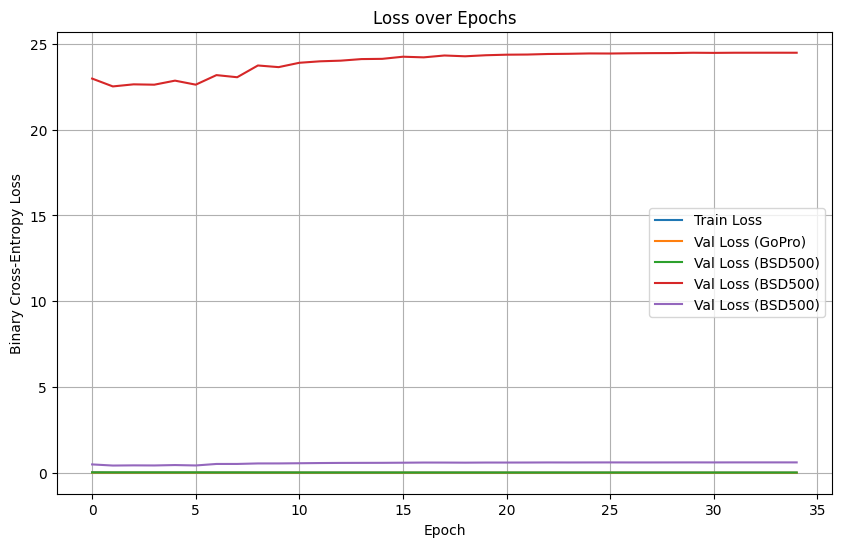

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses_gopro, label="Val Loss (GoPro)")
plt.plot(val_losses_bsd, label="Val Loss (BSD500)")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()



In [26]:
# === Evaluate PSNR and SSIM on test datasets ===
psnr_gopro, ssim_gopro = evaluate_psnr_ssim(autoencoder, test_dataset_gopro)
psnr_bsd, ssim_bsd = evaluate_psnr_ssim(autoencoder, test_dataset_bsd)

print(f"PSNR (GoPro): {psnr_gopro:.2f}, SSIM (GoPro): {ssim_gopro:.4f}")
print(f"PSNR (BSD500): {psnr_bsd:.2f}, SSIM (BSD500): {ssim_bsd:.4f}")



# === Evaluate on test sets ===
print("Test on GoPro:")
autoencoder.evaluate(test_dataset_gopro)

print("Test on BSD500:")
autoencoder.evaluate(test_dataset_bsd)


W0000 00:00:1745858014.367289    2822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745858014.381840    2822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745858014.382422    2822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745858014.382895    2822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745858014.385197    2822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745858014.397039    2822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745858014.399121    2822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745858014.399571    2822 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1745858014.400039    2822 gp

PSNR (GoPro): 29.62, SSIM (GoPro): 0.8900
PSNR (BSD500): 24.33, SSIM (BSD500): 0.6319
Test on GoPro:
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 0.0096 - psnr_metric: 31.3383 - ssim_metric: 0.9226
Test on BSD500:
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - loss: 0.0226 - psnr_metric: 24.4270 - ssim_metric: 0.6290


[0.022601284086704254, 24.32541275024414, 0.6318569779396057]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


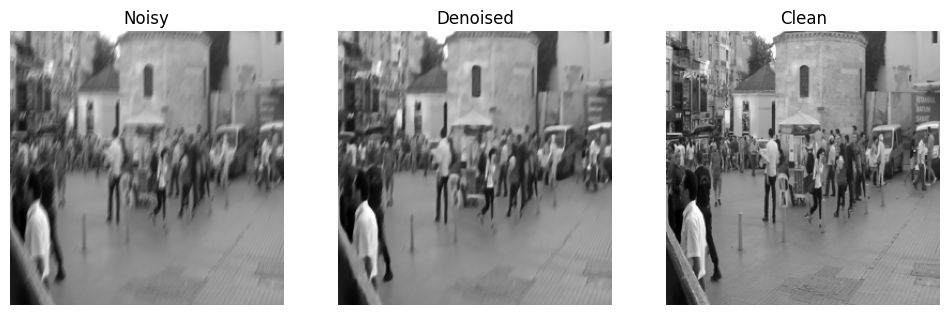

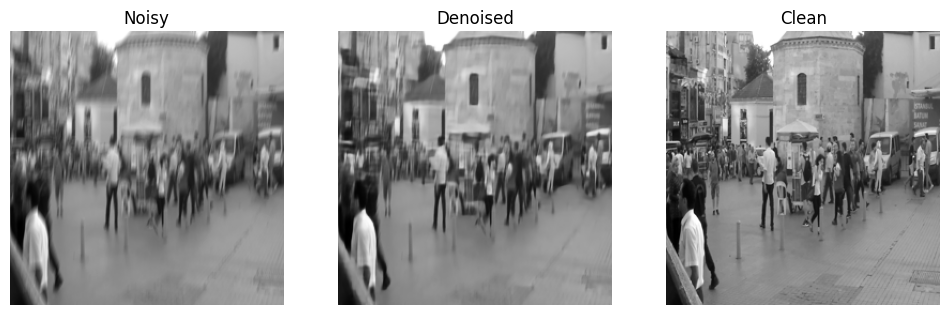

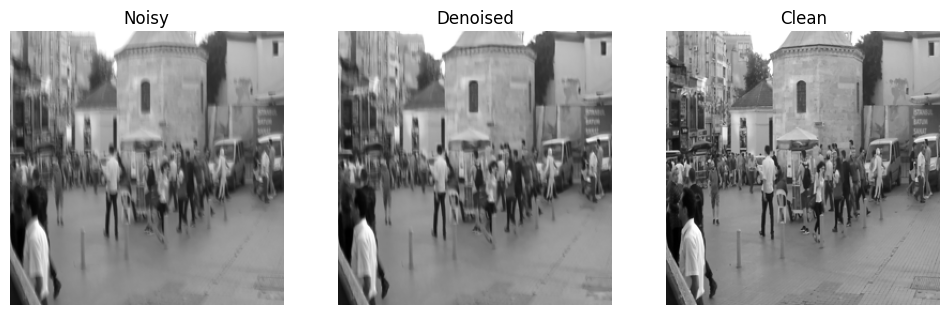

2025-04-28 16:34:18.184724: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
# === Visualize a few test results ===
import matplotlib.pyplot as plt

for noisy, clean in test_dataset_gopro.take(1):
    pred = autoencoder.predict(noisy)

    for i in range(3):  # show 3 examples
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Noisy")
        plt.imshow(noisy[i].numpy().squeeze(), cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Denoised")
        plt.imshow(pred[i].squeeze(), cmap='gray')
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Clean")
        plt.imshow(clean[i].numpy().squeeze(), cmap='gray')
        plt.axis("off")
        plt.show()


References:
https://www.kaggle.com/code/ekojsalim/pres-denoising
https://paperswithcode.com/sota/deblurring-on-gopro
modern: https://www.kaggle.com/code/utkarshsaxenadn/image-denoising-with-auto-encoders
Archaic: https://www.kaggle.com/discussions/questions-and-answers/553140
https://seungjunnah.github.io/Datasets/gopro
https://www.kaggle.com/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500?resource=download